<a href="https://colab.research.google.com/github/alcarvalhox/Projeto-Eddy-Current/blob/master/MiniVGGNet1_Kfold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


INICIO
[INFO] loading images...
Imagens Carregadas
imagens redimensionadas
Imagens tranformadas em matrizes
Processa as imagens
[INFO] processed 500/3329
[INFO] processed 1000/3329
[INFO] processed 1500/3329
[INFO] processed 2000/3329
[INFO] processed 2500/3329
[INFO] processed 3000/3329
Imagens normalizadas
Labels convertidos para vetores
[INFO] compiling model...
------------------------------------------------------------------------
Training for fold 1 ...
[INFO] training network...
Train on 2496 samples, validate on 833 samples
Epoch 1/50
2496/2496 [==============================] - 8s 3ms/step - loss: 1.5614 - accuracy: 0.4764 - val_loss: 1.9602 - val_accuracy: 0.1489
Epoch 2/50
2496/2496 [==============================] - 1s 350us/step - loss: 0.9199 - accuracy: 0.6903 - val_loss: 2.7578 - val_accuracy: 0.1489
Epoch 3/50
2496/2496 [==============================] - 1s 349us/step - loss: 0.7078 - accuracy: 0.7544 - val_loss: 2.8191 - val_accuracy: 0.1489
Epoch 4/50
2496/2496 [===

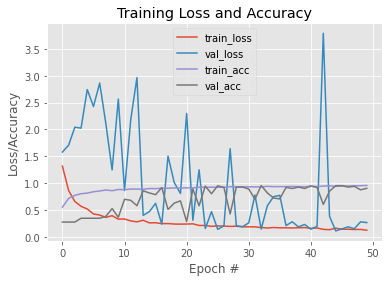

[INFO] sampling images...
[INFO] loading pre-trained network...
[INFO] predicting...


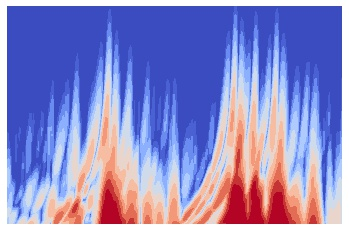

Solda


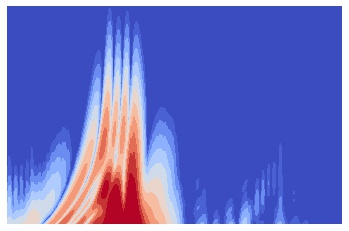

Solda


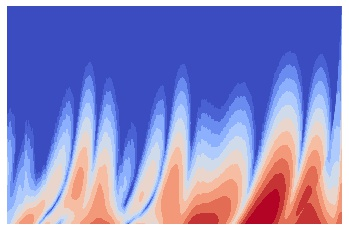

Solda


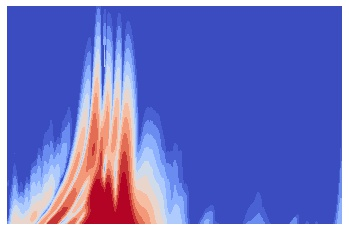

Solda


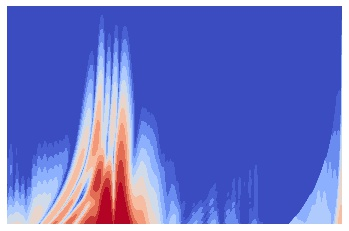

Solda


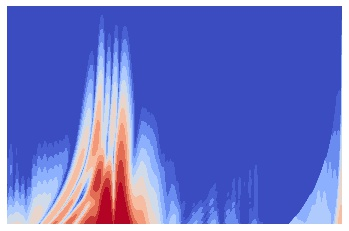

Solda


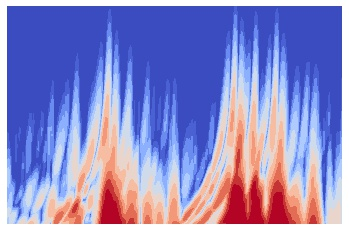

Solda


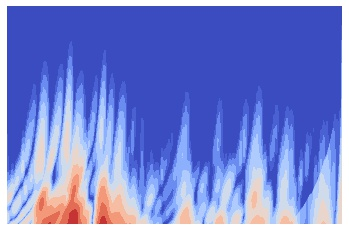

Solda


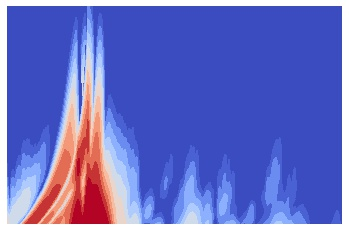

Solda


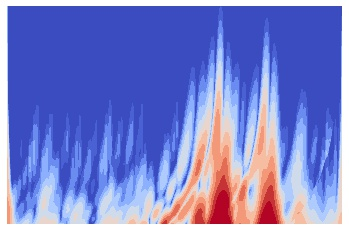

Solda


In [ ]:
# import the necessary packages
%matplotlib inline 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
#from pyimagesearch.preprocessing import ImageToArrayPreprocessor
#from pyimagesearch.preprocessing import SimplePreprocessor
#from pyimagesearch.datasets import SimpleDatasetLoader
#from pyimagesearch.nn.conv import ShallowNet
from imutils import paths
#import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2 
import os 
from keras.preprocessing.image import img_to_array
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.utils import plot_model
from keras.models import load_model
import matplotlib 
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
import pylab as pl
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import Image, display
#!pip install -U ggplot
#!pip install ggplot 
#from ggplot import *
#import ggplot as ggplot


############################
# Transforma Imagem em array
############################
class ImageToArrayPreprocessor:
	def __init__(self, dataFormat=None):
		# store the image data format
		self.dataFormat = dataFormat

	def preprocess(self, image):
		# apply the Keras utility function that correctly rearranges
		# the dimensions of the image
		return img_to_array(image, data_format=self.dataFormat)

####################################################
# Faz o preprocessamento de imagens largura x altura
####################################################
class SimplePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# resize the image to a fixed size, ignoring the aspect
		# ratio
		return cv2.resize(image, (self.width, self.height),
			interpolation=self.inter)
  
###################################
# Carrega os dados e cria os labels
###################################
class SimpleDatasetLoader:
	def __init__(self, preprocessors=None):
		# store the image preprocessor
		self.preprocessors = preprocessors

		# if the preprocessors are None, initialize them as an
		# empty list
		if self.preprocessors is None:
			self.preprocessors = []

	def load(self, imagePaths, verbose=-1):
		# initialize the list of features and labels
		data = []
		labels = []

		# loop over the input images
		for (i, imagePath) in enumerate(imagePaths):
			# load the image and extract the class label assuming
			# that our path has the following format:
			# /path/to/dataset/{class}/{image}.jpg
			image = cv2.imread(imagePath)
			label = imagePath.split(os.path.sep)[-2]

			# check to see if our preprocessors are not None
			if self.preprocessors is not None:
				# loop over the preprocessors and apply each to
				# the image
				for p in self.preprocessors:
					image = p.preprocess(image)

			# treat our processed image as a "feature vector"
			# by updating the data list followed by the labels
			data.append(image)
			labels.append(label)

			# show an update every `verbose` images
			if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
				print("[INFO] processed {}/{}".format(i + 1,
					len(imagePaths)))

		# return a tuple of the data and labels
		return (np.array(data), np.array(labels))
  

############
# MiniVGGNet
############
class MiniVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# first CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# second CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model


# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", required=True,
#	help="path to input dataset")
#ap.add_argument("-m", "--model", required=True,
#	help="path to output model")
#args = vars(ap.parse_args())

# Variáveis de entrada

print('INICIO')

#path = "/content/drive/My Drive/Profissoes/idenprof/train"
path = "/content/drive/My Drive/Projeto Eddy Current/Supervisionado/Figuras_Python_CNN/train3"
#target_names=["chef", "doctor", "engineer","farmer","firefighter","judge","mechanic","pilot","police","waiter"]
target_names=["Cracking","Junta", "Solda","Squat"]

# grab the list of images that we'll be describing
print("[INFO] loading images...")
#imagePaths = list(paths.list_images(args["dataset"]))
imagePaths = list(paths.list_images(path))

print('Imagens Carregadas')

# initialize the image preprocessors
sp = SimplePreprocessor(32, 32)
#sp = SimplePreprocessor(64, 64)
print('imagens redimensionadas')

iap = ImageToArrayPreprocessor()
print('Imagens tranformadas em matrizes')
# load the dataset from disk then scale the raw pixel intensities
# to the range [0, 1]
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
print('Processa as imagens')
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.astype("float") / 255.0
print('Imagens normalizadas')

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, random_state=42)
#print('Imagens divididas treino e teste')
# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)
print('Labels convertidos para vetores')
# initialize the optimizer and model
print("[INFO] compiling model...")

# Número de Folds
num_folds = 5

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Parse numbers as floats
trainX = trainX.astype('float32')
testX = testX.astype('float32')
#trainY = trainY.astype('float32')
#testY = testY.astype('float32')

# Normalize data
trainX = trainX / 255
testX = testX / 255
#trainY = trainY / 255
#testY = testY / 255

# Merge inputs and targets
inputs = np.concatenate((trainX, testX), axis=0)
targets = np.concatenate((trainY, testY), axis=0)
trX = np.concatenate((trainX, testX), axis=0)
trY = np.concatenate((trainY, testY), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  opt = SGD(lr=0.005)
  model = MiniVGGNet.build(width=32, height=32, depth=3, classes=4)
  model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # train the network
  print("[INFO] training network...")
	#history = model.fit(inputs[train], targets[train],
  #            batch_size=batch_size,
  #            epochs=no_epochs,
  #            verbose=verbosity)
  #	H = model.fit(inputs[train], targets[train],
	#      batch_size=32,
  #		  epochs=100,
  #		 	verbose=verbosity)
  H = model.fit(trainX, trainY, validation_data=(testX, testY),
   batch_size=32, epochs=50, verbose=1)
	#H = model.fit(trX,trY,batch_size=32,epochs=50,verbose=1)

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# save the network to disk
#path_modelo = "/content/drive/My Drive/idenprof/idenprof/models/weights.hdf5"
path_modelo = "/content/drive/My Drive/Projeto Eddy Current/Supervisionado/Figuras_Python_CNN/modelo/weights50k5_4classes.hdf5"

print("[INFO] serializing network...")
model.save(path_modelo)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1),
	target_names=["Cracking","Junta", "Solda","Squat"]))
	#target_names=["chef", "doctor", "engineer","farmer","firefighter","judge","mechanic","pilot","police","waiter"]))

# plot the training loss and accuracy
#plt.style.use('classic')


%matplotlib inline
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 50), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


#################################
# Faz a validação do modelo #####
#################################


# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", required=True,
#	help="path to input dataset")
#ap.add_argument("-m", "--model", required=True,
#	help="path to pre-trained model")
#args = vars(ap.parse_args())

# initialize the class labels

#classLabels = ["chef", "doctor", "engineer","farmer","firefighter","judge","mechanic","pilot","police","waiter"]
classLabels = ["Cracking","Junta", "Solda","Squat"]


# grab the list of images in the dataset then randomly sample
# indexes into the image paths list
#path_imagens = "/content/drive/My Drive/idenprof/idenprof/validacao"
print("[INFO] sampling images...")
#imagePaths = np.array(list(paths.list_images("/content/drive/My Drive/idenprof/idenprof/validacao")))
imagePaths = np.array(list(paths.list_images("/content/drive/My Drive/Projeto Eddy Current/Supervisionado/Figuras_Python_CNN/validacao")))

idxs = np.random.randint(0, len(imagePaths), size=(10,))
#idxs = np.random.randint(0, len(imagePaths), size=(2,))
imagePaths = imagePaths[idxs]


# initialize the image preprocessors
sp = SimplePreprocessor(32, 32)
iap = ImageToArrayPreprocessor()

# load the dataset from disk then scale the raw pixel intensities
# to the range [0, 1]
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
(data, labels) = sdl.load(imagePaths)
data = data.astype("float") / 255.0

# load the pre-trained network
#path_modelo = "/content/drive/My Drive/idenprof/idenprof/models/weights.hdf5"
path_modelo = "/content/drive/My Drive/Projeto Eddy Current/Supervisionado/Figuras_Python_CNN/modelo/weights50k5_4classes.hdf5"
print("[INFO] loading pre-trained network...")
model = load_model(path_modelo)

# make predictions on the images
print("[INFO] predicting...")
preds = model.predict(data, batch_size=32).argmax(axis=1)



# loop over the sample images
for (i, imagePath) in enumerate(imagePaths):
	#image = cv2.imread(imagePaths)
  #cv2.putText(image, classLabels[preds[i]], (10,30),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
  #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
	#plt.figure()
  #plt.title("chef")
  #plt.imshow(image)
  #plt.colorbar()
  #plt.grid(False)
  display(Image(imagePath))
  print(classLabels[preds[i]])
  


In [ ]:
trX[2]


array([[[0.00379854, 0.00373702, 0.00372165],
        [0.00369089, 0.00344483, 0.00341407],
        [0.00369089, 0.00346021, 0.00341407],
        ...,
        [0.00369089, 0.00346021, 0.00341407],
        [0.00369089, 0.00346021, 0.00339869],
        [0.00381392, 0.00373702, 0.00373702]],

       [[0.00350634, 0.00292195, 0.00282968],
        [0.00295271, 0.00116878, 0.00090734],
        [0.00295271, 0.00116878, 0.00090734],
        ...,
        [0.00295271, 0.00116878, 0.00090734],
        [0.00295271, 0.00116878, 0.00090734],
        [0.00352172, 0.00293733, 0.00284506]],

       [[0.0035371 , 0.00296809, 0.00286044],
        [0.00295271, 0.00116878, 0.00090734],
        [0.00295271, 0.00116878, 0.00090734],
        ...,
        [0.00295271, 0.00116878, 0.00090734],
        [0.00295271, 0.00116878, 0.00090734],
        [0.0035371 , 0.00293733, 0.00282968]],

       ...,

       [[0.0038293 , 0.00356786, 0.00341407],
        [0.00329104, 0.00330642, 0.00346021],
        [0.002599  , 0